**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with KMeans and DBSCAN</h1>**

In this notebook, we will explore and analyse if KMeans and DBSCAN are good models for grouping TOSP code descriptions to identify inappropriate code pairs. Our analysis involves determining the optimal number of clusters for KMeans using both the Elbow Method and Silhouette Score, as well as finding the best epsilon (ε) and min_samples parameters for DBSCAN.

In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Loading the data (combined_dataset.csv)
df_tosp = pd.read_csv("combined_dataset.csv")

# Extract descriptions and vectorize them using TF‑IDF
descriptions = df_tosp["Description"].tolist()
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(descriptions)

**<h2>Finding the best Epsilon and epsilon (ε) and min_samples for DBSCAN with Grid Search and Silhouette Analysis</h2>**

In contrast, DBSCAN, after a grid search, produced optimal parameters at {'eps': 0.1, 'min_samples': 4} with a remarkably high silhouette score of 0.9373. This high score implies that, for these parameters, the clusters formed are extremely well-defined and the non-noise points are highly similar within clusters. However, a very low epsilon might also indicate that clusters are overly fine-grained, potentially isolating points more than grouping them in a meaningful way.

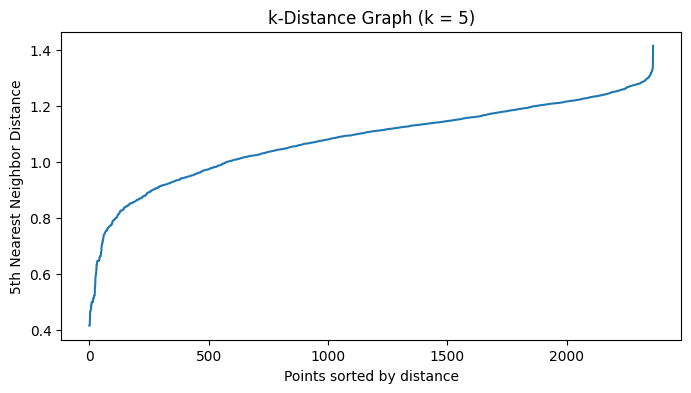

eps: 0.10, min_samples: 3, silhouette score: 0.8790
eps: 0.10, min_samples: 4, silhouette score: 0.9373
eps: 0.10, min_samples: 5, silhouette score: 0.9115
eps: 0.20, min_samples: 3, silhouette score: 0.7768
eps: 0.20, min_samples: 4, silhouette score: 0.8336
eps: 0.20, min_samples: 5, silhouette score: 0.8796
eps: 0.20, min_samples: 6, silhouette score: 0.8880
eps: 0.20, min_samples: 7, silhouette score: 0.8706
eps: 0.30, min_samples: 3, silhouette score: 0.6331
eps: 0.30, min_samples: 4, silhouette score: 0.6505
eps: 0.30, min_samples: 5, silhouette score: 0.6573
eps: 0.30, min_samples: 6, silhouette score: 0.6818
eps: 0.30, min_samples: 7, silhouette score: 0.7144
eps: 0.30, min_samples: 8, silhouette score: 0.8215
eps: 0.30, min_samples: 9, silhouette score: 0.8215
eps: 0.40, min_samples: 3, silhouette score: 0.4869
eps: 0.40, min_samples: 4, silhouette score: 0.4864
eps: 0.40, min_samples: 5, silhouette score: 0.5071
eps: 0.40, min_samples: 6, silhouette score: 0.5063
eps: 0.40, m

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Plot the k-distance graph
min_samples_example = 5
neighbors = NearestNeighbors(n_neighbors=min_samples_example)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
k_distances = np.sort(distances[:, min_samples_example-1], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f'k-Distance Graph (k = {min_samples_example})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples_example}th Nearest Neighbor Distance')
plt.show()

# Grid Search for Optimal DBSCAN Parameters
eps_range = np.linspace(0.1, 1.0, 10)
min_samples_range = range(3, 10)

best_score = -1
best_params = {}

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
        labels = dbscan.fit_predict(X)

        # Check non-noise points and ensure at least 2 clusters among them
        mask = labels != -1
        unique_labels_non_noise = np.unique(labels[mask])
        if len(unique_labels_non_noise) < 2:
            continue

        # Also ensure we have enough non-noise samples
        if np.sum(mask) < 2:
            continue

        try:
            score = silhouette_score(X[mask], labels[mask], metric="cosine")
            print(f"eps: {eps:.2f}, min_samples: {min_samples}, silhouette score: {score:.4f}")
            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}
        except Exception as e:
            print(f"Error for eps: {eps:.2f}, min_samples: {min_samples}: {e}")

print("\nBest parameters:", best_params, "with silhouette score:", best_score)


**<h2>Training the models and comparing TOSP Code Pairs</h2>**

The models were trained using the "optimal" parameters identified in our analysis. Since we do not have access to medical professionals to verify the similarity of the code pairs, our evaluation is based on manual inspection. Specifically, we assess similarity by checking for the presence of repeated keywords—such as "cataract surgery"—in the TOSP code descriptions to infer whether the pairs should be considered similar or different.

In [4]:
# Training KMeans Clustering.
n_clusters = 1200  # Based on silhouette score)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Training DBSCAN Clustering.
dbscan = DBSCAN(eps=0.1, min_samples=4, metric="cosine") # eps and min_samples based on silhouette score also
dbscan_labels = dbscan.fit_predict(X)

# Assign cluster labels to the dataframe.
df_tosp["KMeans_Label"] = kmeans_labels
df_tosp["DBSCAN_Label"] = dbscan_labels

# Defining a function to test a pair of codes.
def test_code_pair(code1, code2, df, vectorizer):
    # Locate the indices of the provided codes
    idx1_list = df.index[df["Code"] == code1].tolist()
    idx2_list = df.index[df["Code"] == code2].tolist()

    if not idx1_list or not idx2_list:
        print(f"One or both codes ({code1}, {code2}) were not found.")
        return

    idx1 = idx1_list[0]
    idx2 = idx2_list[0]

    # Retrieve the TOSP code descriptions
    desc1 = df.loc[idx1, "Description"]
    desc2 = df.loc[idx2, "Description"]

    # Get cluster labels from both KMeans and DBSCAN
    kmeans_label1 = df.loc[idx1, "KMeans_Label"]
    kmeans_label2 = df.loc[idx2, "KMeans_Label"]
    dbscan_label1 = df.loc[idx1, "DBSCAN_Label"]
    dbscan_label2 = df.loc[idx2, "DBSCAN_Label"]

    same_kmeans = (kmeans_label1 == kmeans_label2)
    same_dbscan = (dbscan_label1 == dbscan_label2)

    # Compute cosine similarity using TF‑IDF vectors
    vec1 = vectorizer.transform([desc1])
    vec2 = vectorizer.transform([desc2])
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # Output the results
    print(f"Comparing code pair: {code1} vs {code2}")
    print(f"KMeans -> {code1} in cluster {kmeans_label1}, {code2} in cluster {kmeans_label2}. Same cluster: {same_kmeans}")
    print(f"DBSCAN  -> {code1} in cluster {dbscan_label1}, {code2} in cluster {dbscan_label2}. Same cluster: {same_dbscan}")
    print(f"Cosine similarity (TF‑IDF): {cos_sim:.4f}")

# Test the function with a specific pair of codes
# In example #1 below, we will compare codes "SL701L" and "SL702L"
# As you can see, since both are similar in description, the cosine similarity is high, both KMeans and DBSCAN is clustering them together
test_code_pair("SL701L", "SL702L", df_tosp, vectorizer)

print()

# In example #2 below, we will compare codes "SL702L" and "SL705O"
# KMeans is clustered correctly (both are vastly different opterations) but DBSCAN is incorrectly clustering them together as noise
# The cosine similarity seems to be correct also
test_code_pair("SL701L", "SL705O", df_tosp, vectorizer)

Comparing code pair: SL701L vs SL702L
KMeans -> SL701L in cluster 12, SL702L in cluster 12. Same cluster: True
DBSCAN  -> SL701L in cluster -1, SL702L in cluster -1. Same cluster: True
Cosine similarity (TF‑IDF): 0.9611

Comparing code pair: SL701L vs SL705O
KMeans -> SL701L in cluster 12, SL705O in cluster 416. Same cluster: False
DBSCAN  -> SL701L in cluster -1, SL705O in cluster -1. Same cluster: True
Cosine similarity (TF‑IDF): 0.0000


**<h2>Conclusion</h2>**

Our testing reveals that neither KMeans nor DBSCAN, when applied to TF‑IDF representations of TOSP code descriptions, yields an entirely satisfactory clustering solution for identifying inappropriate code pairs. KMeans appears to overfit the data, forming clusters that are not clearly separated—reflected by a low silhouette score—and splitting codes that, based on domain intuition, should be similar. In contrast, DBSCAN produced a high silhouette score; however, this metric is misleading in this context because many data points are labeled as noise. For example, both SL706L and SM700A were assigned a noise label (–1) by DBSCAN, even though their cosine similarity is 0, indicating they are markedly different. This suggests that a very low ε can result in over-fragmentation, where tight clusters are formed only on a subset of the data while the majority is discarded as noise.

Overall, these findings suggest that the classical clustering models evaluated—KMeans and DBSCAN—may not be ideally suited for this task without further refinement or alternative feature representations. Alternative approaches, such as exploring other clustering techniques or algorithms, should be considered to more effectively capture the nuanced similarities and differences among TOSP code descriptions.
